#initial github data retrieval

In [ ]:
# Install necessary async libraries for Collab
!pip install aiohttp nest_asyncio tqdm

import asyncio
import aiohttp
import pandas as pd
import os
import time
import datetime
import traceback
import math
from google.colab import userdata, drive
from tqdm.asyncio import tqdm
import nest_asyncio

# Apply nest_asyncio to allow nested event loops in Collab
nest_asyncio.apply()

# ==============================================================================
# 1. CONFIGURATION & SETUP
# ==============================================================================

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
OUTPUT_DIR = '/content/drive/MyDrive/clarityloop'
os.makedirs(OUTPUT_DIR, exist_ok=True)

OWNER = 'pandas-dev'
REPO = 'pandas'
MAX_ISSUE_PAGES = 0 # 0 for all pages

# Concurrency Limit
MAX_CONCURRENT_REQUESTS = 20

# Global Buffer for Emergency Saves
GLOBAL_RESULTS_BUFFER = []

# --- SMART TOKEN MANAGEMENT SYSTEM ---
class SmartTokenManager:
    def __init__(self):
        # Structure: [{'token': 'abc', 'reset_at': 0}, ...]
        self.token_data = []
        self.current_index = 0
        self.lock = asyncio.Lock()

        # 1. Load numbered tokens
        i = 1
        while True:
            try:
                t = userdata.get(f'GITHUB_TOKEN_{i}')
                if t:
                    self.token_data.append({'token': t, 'reset_at': 0})
                    print(f"Loaded GITHUB_TOKEN_{i}")
                else:
                    break
            except userdata.SecretNotFoundError:
                break
            i += 1

        # 2. Load standard token
        if not self.token_data:
            try:
                t = userdata.get('GITHUB_TOKEN')
                if t:
                    self.token_data.append({'token': t, 'reset_at': 0})
                    print("Loaded standard GITHUB_TOKEN")
            except userdata.SecretNotFoundError:
                pass

        if not self.token_data:
            raise ValueError("No GitHub tokens found in Colab secrets!")

        print(f"Total tokens managed: {len(self.token_data)}")

    def get_current_headers(self):
        """Returns headers for the currently active token."""
        t_data = self.token_data[self.current_index]
        return {
            'Authorization': f'token {t_data["token"]}',
            'Accept': 'application/vnd.github.v3+json'
        }

    async def report_403_and_rotate(self, failed_index, github_reset_header):
        """
        Called when a 403 occurs.
        Updates the failed token's reset time and finds the next valid one.
        Returns: (should_retry: bool, wait_time: int)
        """
        async with self.lock:
            current_time = time.time()

            # 1. Update the reset time for the token that just failed
            # We add a 10s buffer to be safe
            reset_timestamp = int(github_reset_header) + 10
            self.token_data[failed_index]['reset_at'] = reset_timestamp

            # 2. Check if the index has already changed (another thread rotated it)
            if self.current_index != failed_index:
                # The current token is different from the one that failed.
                # Check if this new current token is valid.
                if self.token_data[self.current_index]['reset_at'] <= current_time:
                    return True, 0

            # 3. Scan ALL tokens to find one that is ready NOW
            for i, t_data in enumerate(self.token_data):
                if t_data['reset_at'] <= current_time:
                    self.current_index = i
                    print(f"\n[!] Rate Limit on Token #{failed_index + 1}. Switching to valid Token #{i + 1}...")
                    return True, 0

            # 4. If we get here, ALL tokens are on timeout.
            # Find the token with the EARLIEST reset time.
            earliest_reset = min(t['reset_at'] for t in self.token_data)
            wait_time = max(earliest_reset - current_time, 0)

            print(f"\n[!] ALL {len(self.token_data)} TOKENS EXHAUSTED.")
            print(f"[!] Earliest reset is in {wait_time/60:.1f} minutes.")

            # We don't change the index; we'll just sleep and retry the current one.
            return False, wait_time

token_manager = SmartTokenManager()

# Caches
user_profile_cache = {}
repo_details_cache = {}

# ==============================================================================
# 2. HELPER FUNCTIONS
# ==============================================================================

def save_checkpoint(reason="CHECKPOINT"):
    if not GLOBAL_RESULTS_BUFFER:
        return

    print(f"\n[SAVE] Initiating {reason} save...")
    try:
        df = pd.DataFrame(GLOBAL_RESULTS_BUFFER)
        if 'created_at' in df.columns:
            df['created_at'] = pd.to_datetime(df['created_at'])
            df.sort_values(by=['created_at', 'record_id'], ascending=[False, True], inplace=True)

        filename = os.path.join(OUTPUT_DIR, f'github_{OWNER}_{REPO}_{reason}.csv')
        df.to_csv(filename, index=False)
        print(f"[SAVE] Success: {filename}")
    except Exception as e:
        print(f"[ERROR] Failed to save checkpoint: {e}")

async def fetch_json(session, url, retries=3):
    if not url: return None, None

    for attempt in range(retries):
        try:
            # Always grab the current index before making the request
            # so we know which token failed if a 403 happens
            attempt_index = token_manager.current_index
            headers = token_manager.get_current_headers()

            async with session.get(url, headers=headers) as response:

                # --- RATE LIMIT HANDLING ---
                if response.status == 403:
                    limit_remaining = response.headers.get('X-RateLimit-Remaining')

                    if limit_remaining == '0':
                        reset_header = response.headers.get('X-RateLimit-Reset', 0)

                        # Ask manager what to do
                        should_retry, wait_time = await token_manager.report_403_and_rotate(attempt_index, reset_header)

                        if should_retry:
                            continue # Try again immediately with the new token

                        # Must sleep (All tokens dead)
                        async with token_manager.lock:
                            # Re-verify we still need to sleep (race condition check)
                            current_time = time.time()
                            # Re-calculate min wait time based on live data
                            earliest = min(t['reset_at'] for t in token_manager.token_data)
                            real_wait = max(earliest - current_time, 0)

                            if real_wait > 0:
                                save_checkpoint("RATE_LIMIT_PAUSE")
                                print(f"[!] Sleeping for {real_wait:.0f} seconds...")
                                await asyncio.sleep(real_wait)

                            continue # Wake up and retry

                if response.status == 200:
                    return await response.json(), response.links

                if response.status == 404:
                    return None, None

                response.raise_for_status()

        except (aiohttp.ClientError, asyncio.TimeoutError) as e:
            if attempt == retries - 1:
                return None, None
            await asyncio.sleep(2)
        except Exception as e:
            print(f"Unexpected error in fetch_json: {e}")
            return None, None

    return None, None

async def fetch_paginated_async(session, start_url, max_pages=0, desc="Fetching", use_progress=False):
    all_items = []
    url = start_url
    page_count = 0

    pbar = None
    if use_progress:
        pbar = tqdm(desc=f"{desc} (Pages)", unit="page", leave=False)

    try:
        while url:
            if max_pages != 0 and page_count >= max_pages:
                break

            data, links = await fetch_json(session, url)

            if not data:
                break

            all_items.extend(data)

            if 'next' in links:
                url = links['next']['url']
                page_count += 1
                if pbar is not None: pbar.update(1)
            else:
                break
    finally:
        if pbar is not None: pbar.close()

    return all_items

async def get_user_full_name_async(session, username):
    if not username: return None
    if username in user_profile_cache: return user_profile_cache[username]
    url = f"https://api.github.com/users/{username}"
    data, _ = await fetch_json(session, url)
    full_name = data.get('name') if data else None
    user_profile_cache[username] = full_name
    return full_name

# ==============================================================================
# 3. CORE LOGIC
# ==============================================================================

async def process_thread(session, issue, semaphore):
    try:
        async with semaphore:
            interactions = []
            is_pr = 'pull_request' in issue

            tasks = []
            tasks.append(get_user_full_name_async(session, issue['user']['login']))

            if is_pr:
                tasks.append(fetch_json(session, issue['pull_request']['url']))
            else:
                tasks.append(asyncio.sleep(0))

            if is_pr:
                reviews_url = f"{issue['pull_request']['url']}/reviews"
                tasks.append(fetch_paginated_async(session, reviews_url, use_progress=False))
            else:
                tasks.append(asyncio.sleep(0))

            if issue['comments'] > 0:
                tasks.append(fetch_paginated_async(session, issue['comments_url'], use_progress=False))
            else:
                tasks.append(asyncio.sleep(0))

            results = await asyncio.gather(*tasks)

            author_full_name = results[0]

            pr_commits, pr_changed_files, pr_additions, pr_deletions = None, None, None, None
            collaborators_set = set()
            collaborators_set.add(issue['user']['login'])

            if is_pr and results[1] and results[1][0]:
                pr_data = results[1][0]
                pr_commits = pr_data.get('commits')
                pr_changed_files = pr_data.get('changed_files')
                pr_additions = pr_data.get('additions')
                pr_deletions = pr_data.get('deletions')

            if is_pr and isinstance(results[2], list):
                for review in results[2]:
                    if review.get('user'):
                        collaborators_set.add(review['user']['login'])

            comments_data = results[3] if isinstance(results[3], list) else []

            main_record = {
                'record_id': issue['id'], 'thread_id': issue['number'], 'parent_id': None,
                'repo': f"{OWNER}/{REPO}",
                'type': 'pull_request_body' if is_pr else 'issue_body',
                'author_id': issue['user']['id'], 'author_username': issue['user']['login'],
                'title': issue.get('title'), 'text_content': issue.get('body'),
                'created_at': issue['created_at'], 'url': issue['html_url'],
                'commits': pr_commits, 'changed_files': pr_changed_files,
                'additions': pr_additions, 'deletions': pr_deletions,
                'workspace_name': OWNER,
                'workspace_title': repo_details_cache.get('desc'),
                'context_type': 'GITHUB_PR' if is_pr else 'GITHUB_ISSUE',
                'author_full_name': author_full_name,
                'author_email_fake': f"{issue['user']['login']}@{REPO}.com",
                'collaborators_fake': "",
                'role_fake': None, 'manager_email_fake': None, 'gender_fake': None, 'ethnicity_fake': None
            }
            interactions.append(main_record)

            comment_name_tasks = []
            for comment in comments_data:
                if comment.get('user'):
                    comment_name_tasks.append(get_user_full_name_async(session, comment['user']['login']))
                else:
                    comment_name_tasks.append(asyncio.sleep(0))

            comment_names = await asyncio.gather(*comment_name_tasks)

            for i, comment in enumerate(comments_data):
                if not comment.get('user'): continue
                commenter_username = comment['user']['login']
                if is_pr: collaborators_set.add(commenter_username)

                interactions.append({
                    'record_id': comment['id'], 'thread_id': issue['number'], 'parent_id': issue['id'],
                    'repo': f"{OWNER}/{REPO}", 'type': 'comment',
                    'author_id': comment['user']['id'], 'author_username': commenter_username,
                    'title': None, 'text_content': comment.get('body'), 'created_at': comment['created_at'],
                    'url': comment['html_url'],
                    'commits': None, 'changed_files': None, 'additions': None, 'deletions': None,
                    'workspace_name': OWNER, 'workspace_title': repo_details_cache.get('desc'),
                    'context_type': None,
                    'author_full_name': comment_names[i],
                    'author_email_fake': f"{commenter_username}@{REPO}.com",
                    'collaborators_fake': "", 'role_fake': None, 'manager_email_fake': None, 'gender_fake': None, 'ethnicity_fake': None
                })

            interactions[0]['collaborators_fake'] = ",".join(sorted(list(collaborators_set)))
            return interactions
    except Exception as e:
        print(f"Error processing thread {issue['number']}: {e}")
        return []

# ==============================================================================
# 4. MAIN ORCHESTRATOR
# ==============================================================================

async def main():
    print(f"Targeting: {OWNER}/{REPO}")
    print(f"Saving to: {OUTPUT_DIR}")

    timeout = aiohttp.ClientTimeout(total=None)

    try:
        async with aiohttp.ClientSession(timeout=timeout) as session:

            print("Fetching repo details...")
            repo_data, _ = await fetch_json(session, f"https://api.github.com/repos/{OWNER}/{REPO}")
            repo_details_cache['desc'] = repo_data.get('description') if repo_data else None

            print("Fetching Issue/PR List (this may take a moment)...")
            issues_url = f'https://api.github.com/repos/{OWNER}/{REPO}/issues?state=all&per_page=100'
            issues_list = await fetch_paginated_async(session, issues_url, MAX_ISSUE_PAGES, desc="Fetching List", use_progress=True)

            total_threads = len(issues_list)
            print(f"\nFound {total_threads} threads. Starting parallel processing...")
            print("Status updates will appear every 10 seconds.")

            semaphore = asyncio.Semaphore(MAX_CONCURRENT_REQUESTS)
            tasks = [process_thread(session, issue, semaphore) for issue in issues_list]

            completed_count = 0
            last_print_time = time.time()

            for f in asyncio.as_completed(tasks):
                try:
                    result = await f
                    GLOBAL_RESULTS_BUFFER.extend(result)
                    completed_count += 1

                    current_time = time.time()
                    if current_time - last_print_time > 10:
                        percent = (completed_count / total_threads) * 100
                        timestamp = datetime.datetime.now().strftime("%H:%M:%S")
                        print(f"[{timestamp}] Progress: {completed_count}/{total_threads} threads processed ({percent:.1f}%)")
                        last_print_time = current_time
                except Exception as e:
                    print(f"Task failed: {e}")

            print(f"--> Finished: {completed_count}/{total_threads} threads processed (100%)")

            if GLOBAL_RESULTS_BUFFER:
                save_checkpoint("FINAL")
            else:
                print("\nNo data processed.")

    except Exception as e:
        print(f"\n[CRITICAL ERROR] Main loop crashed: {e}")
        traceback.print_exc()
        save_checkpoint("CRASH_DUMP")

if __name__ == "__main__":
    asyncio.run(main())

Mounting Google Drive...
Mounted at /content/drive
Loaded GITHUB_TOKEN_1
Loaded GITHUB_TOKEN_2


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import time

from google.colab import drive
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/clarityloop/github_pandas-dev_pandas_FINAL.csv')

Mounted at /content/gdrive


In [ ]:
OWNER = 'wordpress'
REPO = 'wordpress-develop'

# further data processing


## number amount of all cases per user

In [ ]:
# --- Cell 1: User Case Summary ---

print("Analyzing user case submissions...")

# filter for only the records that start a thread (issues or PRs)
case_starters_df = df[df['type'].isin(['issue_body', 'pull_request_body'])].copy()

if not case_starters_df.empty:
    # group by author and aggregate the results
    # count the number of cases and also list the specific thread IDs for each user
    user_summary = case_starters_df.groupby(['author_id', 'author_username']).agg(
        cases_started=('thread_id', 'count'),
        total_commits=('commits', 'sum'),
        total_additions=('additions', 'sum'),
        total_deletions=('deletions', 'sum'),
        total_files_changed=('changed_files', 'sum'),
        case_list=('thread_id', lambda x: list(x))
    ).sort_values(by='cases_started', ascending=False).reset_index()

    # save the summary to a new CSV file
    summary_filename = f'user_case_amount_{OWNER}_{REPO}.csv'
    user_summary.to_csv(summary_filename, index=False)
    print(f"\nUser case summary saved to '{summary_filename}'")

    # display the top 20 users who started the most cases
    print("\n--- Top 20 Users by Cases Started ---")
    print(user_summary.head(20).to_string())
else:
    print("No issue or pull request bodies found in the dataset to analyze.")

Analyzing user case submissions...

User case summary saved to 'user_case_amount_pandas-dev_pandas.csv'

--- Top 20 Users by Cases Started ---
    author_id     author_username  cases_started  total_commits  total_additions  total_deletions  total_files_changed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          case_list
0     8078968        jbrockmend

## view specific case/thread

In [ ]:
#1586, 1683, 1454
#[1701, 1681, 1660, 1653, 1645, 1639, 1635, 1634, 1633, 1632, 1627, 1622, 1619, 1615, 1614, 1612, 1606, 1603, 1602, 1589, 1577, 1574, 1573, 1572, 1571, 1570, 1568, 1565, 1553, 1543, 1538, 1518]
#[1706, 1705, 1704, 1703, 1671, 1670, 1668, 1658, 1657, 1640, 1608, 1586, 1585, 1582, 1556, 1554, 1545, 1534, 1531, 1529, 1515]
#[1692, 1648, 1647, 1646, 1644, 1604, 1587, 1579, 1575, 1569, 1549, 1533, 1532, 1528, 1527, 1524, 1523, 1522]

# replace with relevant thread_id
THREAD_ID_TO_VIEW = 63303

print(f"--- Displaying full conversation and all metadata for Thread #{THREAD_ID_TO_VIEW} ---")

# filter the main dataframe for the specified thread_id
thread_df = df[df['thread_id'] == THREAD_ID_TO_VIEW].copy()

if not thread_df.empty:
    # sort the interactions by date to ensure chronological order
    thread_df['created_at'] = pd.to_datetime(thread_df['created_at'])
    thread_df = thread_df.sort_values(by='created_at')

    # --- NEW: Get the main case record to display header info ---
    case_header = thread_df.iloc[0]

    print("\n" + "="*80)
    print(f"CASE HEADER: #{case_header['thread_id']} - {case_header['title']}")
    print(f"URL: {case_header['url']}")
    print(f"Author: {case_header['author_username']} | Type: {case_header['type']}")
    print("="*80)

    # --- NEW: Display PR-specific stats if they exist ---
    if case_header['type'] == 'pull_request_body':
        print("Pull Request Stats:")
        print(f"  - Commits: {int(case_header['commits'])}")
        print(f"  - Files Changed: {int(case_header['changed_files'])}")
        print(f"  - Additions: {int(case_header['additions'])}")
        print(f"  - Deletions: {int(case_header['deletions'])}")
        print("="*80)

    print("\n--- CONVERSATION LOG ---")
    # loop through each record in the conversation to display its content
    for index, row in thread_df.iterrows():
        print(f"\n[{row['created_at']}] - {row['author_username']} ({row['type']}):")
        print("-" * 80)
        print(row['text_content'])

    # save this specific thread to its own CSV file
    case_filename = f'case_{THREAD_ID_TO_VIEW}_detail.csv'
    thread_df.to_csv(case_filename, index=False)
    print(f"\n\nSuccessfully saved full case details to '{case_filename}'")
else:
    print(f"No data found for Thread ID: {THREAD_ID_TO_VIEW}. Please check the number.")

--- Displaying full conversation and all metadata for Thread #63303 ---

CASE HEADER: #63303 - API: to_timedelta(ints, unit) give requested unit
URL: https://github.com/pandas-dev/pandas/pull/63303
Author: jbrockmendel | Type: pull_request_body
Pull Request Stats:
  - Commits: 11
  - Files Changed: 15
  - Additions: 56
  - Deletions: 36

--- CONVERSATION LOG ---

[2025-12-08 21:15:51+00:00] - jbrockmendel (pull_request_body):
--------------------------------------------------------------------------------
- [x] part of #63275
- [x] [Tests added and passed](https://pandas.pydata.org/pandas-docs/dev/development/contributing_codebase.html#writing-tests) if fixing a bug or adding a new feature
- [ ] All [code checks passed](https://pandas.pydata.org/pandas-docs/dev/development/contributing_codebase.html#pre-commit).
- [ ] Added [type annotations](https://pandas.pydata.org/pandas-docs/dev/development/contributing_codebase.html#type-hints) to new arguments/methods/functions.
- [ ] Added an e

## list of feedback givers per case per user

In [ ]:
# Replace with a real username from your dataset
USERNAME_TO_ANALYZE = 'tuhinsharma121'

print(f"--- Analyzing feedback received by user: {USERNAME_TO_ANALYZE} ---")

# find all cases (threads) started by the specified user
user_cases_df = df[
    (df['author_username'] == USERNAME_TO_ANALYZE) &
    (df['type'].isin(['issue_body', 'pull_request_body']))
].copy()

if not user_cases_df.empty:
    user_thread_ids = user_cases_df['thread_id'].unique()
    print(f"Found {len(user_thread_ids)} cases started by this user.")

    feedback_summary = []

    # for each case, find all other users who commented
    for thread_id in user_thread_ids:
        # get all comments for this specific thread
        comments_in_thread = df[
            (df['thread_id'] == thread_id) &
            (df['type'] == 'comment')
        ]

        # find unique authors of the comments, excluding the user themselves
        feedback_givers = comments_in_thread[
            comments_in_thread['author_username'] != USERNAME_TO_ANALYZE
        ]['author_username'].unique().tolist()

        # get the title and URL for this thread from our user_cases_df ---
        case_info = user_cases_df[user_cases_df['thread_id'] == thread_id].iloc[0]
        thread_url = case_info['url']
        thread_title = case_info['title']

        feedback_summary.append({
            'case_thread_id': thread_id,
            'case_title': thread_title, # Add title for context
            'case_url': thread_url,
            'feedback_givers': ", ".join(feedback_givers)
        })

    # convert the summary to a DataFrame and display it
    feedback_df = pd.DataFrame(feedback_summary)

    print("\n--- Summary of Feedback Givers per Case ---")
    print(feedback_df.to_string())

    # save the summary to a new CSV file
    feedback_filename = f'user_feedback_{USERNAME_TO_ANALYZE}.csv'
    feedback_df.to_csv(feedback_filename, index=False)
    print(f"\nSuccessfully saved feedback summary to '{feedback_filename}'")

else:
    print(f"No cases started by the user '{USERNAME_TO_ANALYZE}' were found in the dataset.")

--- Analyzing feedback received by user: tuhinsharma121 ---
Found 333 cases started by this user.

--- Summary of Feedback Givers per Case ---
     case_thread_id                                                                                                                                                  case_title                                           case_url                               feedback_givers
0             63556                                                                                                               DOC: Fix SA01 for pandas.StringDtype.na_value    https://github.com/pandas-dev/pandas/pull/63556                                              
1             63555                                                                                                               DOC: Fix SA01 for pandas.StringDtype.na_value  https://github.com/pandas-dev/pandas/issues/63555                                              
2             63554                   

# dataset split to 5 csv's

In [ ]:
import pandas as pd

# --- Filtering Control Panel ---

FILTER_TIME_CUTOFF_MONTHS = 24
FILTER_MIN_COMMENTS_PER_CASE = 2
FILTER_MIN_CASES_PER_USER = 4
FILTER_BOT_KEYWORDS = ['[bot]', '-bot', 'bot-']
# FILTER_MIN_CONTENT_LENGTH = 20

# todo: add more stats stuff, to see who has a large ammount of feedback after dataset.

In [ ]:
# ==============================================================================
# --- Apply Filters and Generate Final CSVs ---
# ==============================================================================
if 'df' not in locals():
    raise NameError("DataFrame 'df' not found. Please run your data scraping cell first.")

# --- Step 1: Perform Initial, Non-Contextual Filtering ---
print("Applying initial filters...")
master_df = df.copy()

master_df['created_at'] = pd.to_datetime(master_df['created_at'], utc=True)

if FILTER_TIME_CUTOFF_MONTHS > 0:
    cutoff_date = pd.Timestamp.now(tz='UTC') - pd.DateOffset(months=FILTER_TIME_CUTOFF_MONTHS)
    master_df = master_df[master_df['created_at'] >= cutoff_date]
print(f"Records after time filter: {len(master_df)}")


# --- Step 2: Identify Who and What to Keep ---
print("\nAnalyzing dataset to identify valuable users and threads...")

# 1. Separate Humans and Bots STRICTLY
bot_pattern = '|'.join(FILTER_BOT_KEYWORDS)
is_bot = master_df['author_username'].str.contains(bot_pattern, case=False, na=False)
human_interactions_df = master_df[~is_bot].copy() # We will use THIS for the final output
print(f"Removed {is_bot.sum()} bot interactions (cases & comments).")

# 2. Count comments per thread (using ONLY human comments)
human_comments_df = human_interactions_df[human_interactions_df['type'] == 'comment']
comment_counts = human_comments_df.groupby('thread_id').size()
threads_with_enough_feedback = comment_counts[comment_counts >= FILTER_MIN_COMMENTS_PER_CASE].index
print(f"Found {len(threads_with_enough_feedback)} threads with sufficient human feedback.")

# 3. Find active users (using ONLY human case starters)
human_case_starters_df = human_interactions_df[human_interactions_df['type'].isin(['issue_body', 'pull_request_body'])]
case_counts = human_case_starters_df.groupby('author_id').size()
active_human_users = case_counts[case_counts >= FILTER_MIN_CASES_PER_USER].index
print(f"Found {len(active_human_users)} active human users who start cases.")


# --- Step 3: Create the Final, Clean Dataset ---
print("\nAssembling the final, filtered dataset...")

# We build final_df from 'human_interactions_df' to ensure NO BOTS exist in the output
# Criteria A: Keep any thread (case + comments) that has enough feedback
df_valuable_conversations = human_interactions_df[human_interactions_df['thread_id'].isin(threads_with_enough_feedback)]

# Criteria B: Keep any thread started by a "Core User" (even if it has low feedback)
# This ensures we don't lose the work of your main contributors
active_user_threads = human_case_starters_df[human_case_starters_df['author_id'].isin(active_human_users)]['thread_id']
df_active_users_work = human_interactions_df[human_interactions_df['thread_id'].isin(active_user_threads)]

# Combine and deduplicate
final_df = pd.concat([df_valuable_conversations, df_active_users_work]).drop_duplicates(subset=['record_id']).sort_values(by=['thread_id', 'created_at'])

print(f"Total records in the final, filtered dataset: {len(final_df)}")


# --- Step 4: Generate the 5 Target CSV files ---
print("\nGenerating final CSV files...")

if not final_df.empty:
    # CHANGE EMAIL ADDRESS
    TARGET_EMAIL_DOMAIN = "example.com"
    final_df['author_email_fake'] = final_df['author_username'] + '@' + TARGET_EMAIL_DOMAIN

    # 1. workspaces.csv
    workspaces_df = final_df[['workspace_name', 'workspace_title']].drop_duplicates().copy()
    workspaces_df['owner_email'] = f"owner@{TARGET_EMAIL_DOMAIN}"
    workspaces_df = workspaces_df.rename(columns={'workspace_title': 'title'})
    workspaces_df.to_csv('workspaces.csv', index=False)
    print(f"-> workspaces.csv created with {len(workspaces_df)} records.")

    # 2. users.csv
    # NOTE: 'final_df' contains comments, so this captures users who ONLY commented too.
    users_df = final_df[['author_full_name', 'author_email_fake']].drop_duplicates('author_email_fake').copy()
    users_df = users_df.rename(columns={'author_full_name': 'name', 'author_email_fake': 'email'})
    users_df['gender'] = 'UNKNOWN'
    users_df['ethnicity'] = 'UNKNOWN'
    users_df.to_csv('users.csv', index=False)
    print(f"-> users.csv created with {len(users_df)} records.")

    # 3. workspace_members.csv
    members_df = final_df[['workspace_name', 'author_email_fake']].drop_duplicates().copy()
    members_df = members_df.rename(columns={'author_email_fake': 'user_email'})
    members_df['role'] = 'MEMBER'
    members_df['title'] = 'Contributor'
    members_df['manager_email'] = f"manager@{TARGET_EMAIL_DOMAIN}"
    members_df.to_csv('workspace_members.csv', index=False)
    print(f"-> workspace_members.csv created with {len(members_df)} records.")

    # 4. contexts.csv
    # Only pull 'case starters' (bodies) from the final filtered list
    contexts_df = final_df[final_df['parent_id'].isna()].copy()
    contexts_df = contexts_df.rename(columns={
        'author_email_fake': 'author_email', 'url': 'link', 'text_content': 'body',
        'author_username': 'user', 'collaborators_fake': 'collaborators'
    })
    contexts_df['description'] = contexts_df['body'].str.slice(0, 200) + '...'

    contexts_df['author'] = None
    contexts_df['content'] = None
    contexts_df['key'] = None
    contexts_df['reporter'] = None

    contexts_df = contexts_df[[
        'workspace_name', 'author_email', 'link', 'context_type', 'title', 'created_at',
        'user', 'description', 'body', 'author', 'content', 'key', 'reporter', 'collaborators'
    ]]
    contexts_df.to_csv('contexts.csv', index=False)
    print(f"-> contexts.csv created with {len(contexts_df)} records.")

    # 5. context_comments.csv
    comments_df = final_df[final_df['parent_id'].notna()].copy()

    # Create map using the original dataframe to ensure we catch parents even if the parent body was filtered out
    # (e.g. if we kept a thread due to high comments, but the parent body was lost for some reason, though logic above prevents this for bots)
    parent_urls = df.drop_duplicates('record_id').set_index('record_id')['url']

    comments_df['context_link'] = comments_df['parent_id'].map(parent_urls)
    comments_df = comments_df.rename(columns={
        'author_email_fake': 'comment_author_email',
        'text_content': 'comment_content',
        'url': 'comment_link'
    })
    comments_df = comments_df[['context_link', 'comment_author_email', 'comment_content', 'comment_link']]
    comments_df.to_csv('context_comments.csv', index=False)
    print(f"-> context_comments.csv created with {len(comments_df)} records.")

else:
    print("The dataset is empty after applying filters. No CSV files were generated.")

# ==============================================================================
# --- FINAL STATS & ANALYSIS (TODO COMPLETED) ---
# ==============================================================================
print("\n" + "="*50)
print("       DATASET RICHNESS ANALYSIS")
print("="*50)

# 1. Top 20 Users by Case Richness (Cases + Feedback Volume)
# We want to see users who start cases that actually generate discussion.
print("\n--- Top 20 Users by Contribution & Engagement ---")

# Join cases with comment counts
case_feedback_counts = final_df[final_df['parent_id'].notna()].groupby('thread_id').size().reset_index(name='feedback_count')
cases_with_feedback = final_df[final_df['parent_id'].isna()].merge(case_feedback_counts, on='thread_id', how='left').fillna(0)

# Aggregate per user
user_richness = cases_with_feedback.groupby(['author_username', 'author_email_fake']).agg(
    total_cases=('thread_id', 'count'),
    avg_feedback_per_case=('feedback_count', 'mean'),
    total_feedback_received=('feedback_count', 'sum')
).sort_values(by='total_cases', ascending=False)

# Display
print(user_richness.head(20).to_string())

# Save this analysis for review
stats_filename = f'stats_top_users_{OWNER}_{REPO}.csv'
user_richness.to_csv(stats_filename)
print(f"\n-> Saved detailed user stats to: {stats_filename}")

# 2. "Comment-Only" Contributors
# Users who are valuable for their feedback but haven't started cases in this dataset.
print("\n--- Identifying 'Feedback-Only' Members ---")

all_authors = set(final_df['author_username'].unique())
case_starters = set(final_df[final_df['parent_id'].isna()]['author_username'].unique())
feedback_only_users = list(all_authors - case_starters)

print(f"Found {len(feedback_only_users)} users who provide feedback but did not start cases.")
if feedback_only_users:
    # Print as a single line string as requested
    print(f"List: {', '.join(sorted(feedback_only_users)[:50])} ... (showing first 50)")

print("\n" + "="*50)

Applying initial filters...
Records after time filter: 28872

Analyzing dataset to identify valuable users and threads...
Removed 20242 bot interactions (cases & comments).
Found 1385 threads with sufficient human feedback.
Found 67 active human users who start cases.

Assembling the final, filtered dataset...
Total records in the final, filtered dataset: 6846

Generating final CSV files...
-> workspaces.csv created with 1 records.
-> users.csv created with 790 records.
-> workspace_members.csv created with 790 records.
-> contexts.csv created with 1371 records.
-> context_comments.csv created with 5475 records.

       DATASET RICHNESS ANALYSIS

--- Top 20 Users by Contribution & Engagement ---
                                             total_cases  avg_feedback_per_case  total_feedback_received
author_username author_email_fake                                                                       
rhshadrach      rhshadrach@example.com               214               1.186916      

## final cleaning/demographic generator/consistency check

In [ ]:
!pip install Faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import random
from faker import Faker

# Initialize Faker
fake = Faker()

# ==============================================================================
# --- Post-Processing & Cleaning Cell ---
# ==============================================================================
print("Starting post-processing of CSV files...")

# --- Helper Function for Name Generation ---
def generate_human_name(row):
    # Extract username from the fake email
    username = str(row['email']).split('@')[0]
    current_name = str(row['name']) if pd.notna(row['name']) else ""
    gender = row.get('gender')

    # VALIDATION CHECKS:
    # 1. Name must exist.
    # 2. Name must NOT match the username.
    # 3. Name must contain a space.
    if (current_name and
        current_name.lower() != username.lower() and
        ' ' in current_name):
        return current_name

    # TRY DERIVATION:
    clean_user = username.replace('-', ' ').replace('.', ' ').replace('_', ' ')
    if ' ' in clean_user and not any(char.isdigit() for char in clean_user):
        return clean_user.title()

    # FALLBACK: Generate gender-aware "Forename Surname"
    if gender == 'MALE':
        return f"{fake.first_name_male()} {fake.last_name()}"
    elif gender == 'FEMALE':
        return f"{fake.first_name_female()} {fake.last_name()}"
    else:
        # Non-binary or Unknown: use generic generator
        return f"{fake.first_name()} {fake.last_name()}"

# --- 1. Fix contexts.csv ---
try:
    contexts_df = pd.read_csv('contexts.csv')
    contexts_df['description'] = contexts_df['title']

    # We update the author column to use the generated names later,
    # but for now, we ensure it's not empty by using the user handle as fallback
    #contexts_df['author'] = contexts_df['user']
    #contexts_df['content'] = contexts_df['title']
    #contexts_df['key'] = "GH-" + contexts_df['link'].str.extract(r'issues/(\d+)', expand=False).fillna('0')

    def fix_collaborators(row):
        raw_collabs = str(row['collaborators'])
        if pd.isna(row['collaborators']) or raw_collabs.strip() == '':
            return ''

        # Derive the correct domain (e.g., "stripe-python.com") from the author_email
        # This ensures the collaborators have the same email format as the author
        try:
            domain = str(row['author_email']).split('@')[1]
        except IndexError:
            domain = "github.com" # Fallback

        usernames = raw_collabs.split(',')
        cleaned_emails = []

        for u in usernames:
            u = u.strip()
            # Filter out standard bots and specifically 'github-actions'
            if ('[bot]' in u.lower() or
                u.lower().endswith('-bot') or
                u.lower().startswith('bot-') or
                u == 'github-actions'):
                continue

            # Format as email
            cleaned_emails.append(f"{u}@{domain}")

        return ",".join(cleaned_emails)

    contexts_df['collaborators'] = contexts_df.apply(fix_collaborators, axis=1)

    contexts_df.to_csv('contexts.csv', index=False)
    print("-> contexts.csv updated.")

except FileNotFoundError:
    print("Error: contexts.csv not found.")


# --- 2. Fix users.csv (Names & Demographics) ---
try:
    users_df = pd.read_csv('users.csv')

    # SOLUTION FOR DEMOGRAPHICS (Moved FIRST so names can use gender):
    possible_genders = ['MALE', 'FEMALE']
    possible_ethnicities = ['CAUCASIAN', 'ASIAN', 'HISPANIC', 'AFRICAN_AMERICAN']

    users_df['gender'] = users_df['gender'].apply(lambda x: random.choice(possible_genders))
    users_df['ethnicity'] = users_df['ethnicity'].apply(lambda x: random.choice(possible_ethnicities))

    # SOLUTION FOR NAMES (Applied SECOND):
    users_df['name'] = users_df.apply(generate_human_name, axis=1)

    users_df.to_csv('users.csv', index=False)
    print("-> users.csv updated: Realistic names and random demographics applied.")

except FileNotFoundError:
    print("Error: users.csv not found.")


# --- 3. Fix workspace_members.csv ---
try:
    members_df = pd.read_csv('workspace_members.csv')
    members_df['role'] = members_df['role'].fillna('MEMBER')
    members_df.to_csv('workspace_members.csv', index=False)
    print("-> workspace_members.csv verified.")

except FileNotFoundError:
    print("Error: workspace_members.csv not found.")

print("\nPost-processing complete. Your dataset is ready for upload.")

Starting post-processing of CSV files...
-> contexts.csv updated.
-> users.csv updated: Realistic names and random demographics applied.
-> workspace_members.csv verified.

Post-processing complete. Your dataset is ready for upload.


In [ ]:
# ==============================================================================
# Cell 5: Long-Term Contributor (Consistent) Dataset Generation
# ==============================================================================
# GOAL: Identify "Core Contributors" who have consistently started cases
# (Issues/PRs) every single year for the last N years.

if 'df' not in locals():
    raise NameError("DataFrame 'df' not found. Please run your data scraping cell first.")

print("Generating 'Long-Term Consistent Contributor' Dataset...")

# --- Configuration ---
LTC_MIN_YEARS_ACTIVE = 3 # Number of consecutive recent years required
LTC_MIN_COMMENTS_QUALITY = 2 # Min comments on a case to consider it "collaboration"
TARGET_EMAIL_DOMAIN = "example.com"
OUTPUT_PREFIX = ""

# 1. Prepare Data
ltc_df = df.copy()
ltc_df['created_at'] = pd.to_datetime(ltc_df['created_at'], utc=True)

# 2. Filter Bots
bot_pattern = '|'.join(['\\[bot\\]', '-bot', 'bot-'])
ltc_df = ltc_df[~ltc_df['author_username'].str.contains(bot_pattern, case=False, na=False)]

# 3. Identify Consistent Users (The Rolling Window Logic)
print(f"\nAnalyzing consistency over the last {LTC_MIN_YEARS_ACTIVE} years...")

# Determine the anchor date (the "Present") based on the dataset
latest_date = ltc_df['created_at'].max()
cutoff_date = latest_date - pd.DateOffset(years=LTC_MIN_YEARS_ACTIVE)
print(f"Window: {cutoff_date.date()} to {latest_date.date()}")

# Filter to only Case Starters (Issues/PRs) for the consistency check
case_starters = ltc_df[ltc_df['type'].isin(['issue_body', 'pull_request_body'])]

consistent_users = []

# Group by user to check their timeline
for username, group in case_starters.groupby('author_username'):
    is_consistent = True

    # Check every single year-long window going backwards
    for i in range(LTC_MIN_YEARS_ACTIVE):
        # Window definition: [Present - (i+1) years] to [Present - i years]
        window_end = latest_date - pd.DateOffset(years=i)
        window_start = latest_date - pd.DateOffset(years=i+1)

        # Does the user have a case in this specific window?
        has_case_in_window = not group[
            (group['created_at'] > window_start) &
            (group['created_at'] <= window_end)
        ].empty

        if not has_case_in_window:
            is_consistent = False
            break

    if is_consistent:
        consistent_users.append(username)

print(f"Found {len(consistent_users)} users who have started a case EVERY year for the last {LTC_MIN_YEARS_ACTIVE} years.")

# 4. Filter Dataset
# A. Only keep these specific users
ltc_filtered = ltc_df[ltc_df['author_username'].isin(consistent_users)].copy()

# B. Only keep records strictly WITHIN the time window (exclude their ancient history)
ltc_filtered = ltc_filtered[ltc_filtered['created_at'] > cutoff_date]

# 5. Apply Quality Control (Min Comments per Case)
comments_only = ltc_filtered[ltc_filtered['type'] == 'comment']
valid_threads = comments_only.groupby('thread_id').size()
valid_thread_ids = valid_threads[valid_threads >= LTC_MIN_COMMENTS_QUALITY].index

final_ltc_df = ltc_filtered[ltc_filtered['thread_id'].isin(valid_thread_ids)].copy()

print(f"Final Long-Term Dataset Size: {len(final_ltc_df)} records.")

# ==============================================================================
# Generate the 5 Target CSVs
# ==============================================================================
if not final_ltc_df.empty:
    print(f"\nGenerating CSVs with prefix '{OUTPUT_PREFIX}'...")

    final_ltc_df['author_email_fake'] = final_ltc_df['author_username'] + '@' + TARGET_EMAIL_DOMAIN

    # 1. Workspaces
    ws = final_ltc_df[['workspace_name', 'workspace_title']].drop_duplicates().copy()
    ws['owner_email'] = f"owner@{TARGET_EMAIL_DOMAIN}"
    ws = ws.rename(columns={'workspace_title': 'title'})
    ws.to_csv(f'{OUTPUT_PREFIX}workspaces.csv', index=False)

    # 2. Users
    us = final_ltc_df[['author_full_name', 'author_email_fake']].drop_duplicates('author_email_fake').copy()
    us = us.rename(columns={'author_full_name': 'name', 'author_email_fake': 'email'})
    us['gender'] = 'UNKNOWN'
    us['ethnicity'] = 'UNKNOWN'
    us.to_csv(f'{OUTPUT_PREFIX}users.csv', index=False)

    # 3. Members
    mem = final_ltc_df[['workspace_name', 'author_email_fake']].drop_duplicates().copy()
    mem = mem.rename(columns={'author_email_fake': 'user_email'})
    mem['role'] = 'MEMBER'
    mem['title'] = 'Senior Contributor'
    mem['manager_email'] = f"manager@{TARGET_EMAIL_DOMAIN}"
    mem.to_csv(f'{OUTPUT_PREFIX}workspace_members.csv', index=False)

    # 4. Contexts
    ctx = final_ltc_df[final_ltc_df['parent_id'].isna()].copy()
    ctx = ctx.rename(columns={
        'author_email_fake': 'author_email', 'url': 'link', 'text_content': 'body',
        'author_username': 'user', 'collaborators_fake': 'collaborators'
    })
    ctx['description'] = ctx['body'].str.slice(0, 200) + '...'
    ctx['author'] = None; ctx['content'] = None; ctx['key'] = None; ctx['reporter'] = None

    ctx_cols = ['workspace_name', 'author_email', 'link', 'context_type', 'title', 'created_at',
                'user', 'description', 'body', 'author', 'content', 'key', 'reporter', 'collaborators']
    ctx[ctx_cols].to_csv(f'{OUTPUT_PREFIX}contexts.csv', index=False)

    # 5. Comments
    com = final_ltc_df[final_ltc_df['parent_id'].notna()].copy()
    parent_urls = df.drop_duplicates('record_id').set_index('record_id')['url']
    com['context_link'] = com['parent_id'].map(parent_urls)
    com = com.rename(columns={
        'author_email_fake': 'comment_author_email',
        'text_content': 'comment_content',
        'url': 'comment_link'
    })
    com[['context_link', 'comment_author_email', 'comment_content', 'comment_link']].to_csv(f'{OUTPUT_PREFIX}context_comments.csv', index=False)


    # --- ADDED PRINT STATEMENTS HERE ---
    print(f"-> {OUTPUT_PREFIX}workspaces.csv created with {len(ws)} records.")
    print(f"-> {OUTPUT_PREFIX}users.csv created with {len(us)} records.")
    print(f"-> {OUTPUT_PREFIX}workspace_members.csv created with {len(mem)} records.")
    print(f"-> {OUTPUT_PREFIX}contexts.csv created with {len(ctx)} records.")
    print(f"-> {OUTPUT_PREFIX}context_comments.csv created with {len(com)} records.")
    # -----------------------------------

    print(f"-> Success! All files generated starting with '{OUTPUT_PREFIX}'.")

# ==============================================================================
# --- FINAL STATS & ANALYSIS (LONG-TERM CONTRIBUTORS) ---
# ==============================================================================
print("\n" + "="*50)
print("       LONG-TERM CONTRIBUTOR DATASET ANALYSIS")
print("="*50)

if not final_ltc_df.empty:
    # 1. Top 20 Long-Term Users by Case Richness
    print("\n--- Top 20 Consistent Users by Contribution & Engagement ---")

    ltc_case_feedback_counts = final_ltc_df[final_ltc_df['parent_id'].notna()].groupby('thread_id').size().reset_index(name='feedback_count')
    ltc_cases_with_feedback = final_ltc_df[final_ltc_df['parent_id'].isna()].merge(ltc_case_feedback_counts, on='thread_id', how='left').fillna(0)

    ltc_user_richness = ltc_cases_with_feedback.groupby(['author_username', 'author_email_fake']).agg(
        total_cases=('thread_id', 'count'),
        avg_feedback_per_case=('feedback_count', 'mean'),
        total_feedback_received=('feedback_count', 'sum')
    ).sort_values(by='total_cases', ascending=False)

    print(ltc_user_richness.head(20).to_string())

    ltc_stats_filename = f'{OUTPUT_PREFIX}stats_top_users_{OWNER}_{REPO}.csv'
    ltc_user_richness.to_csv(ltc_stats_filename)
    print(f"\n-> Saved detailed user stats to: {ltc_stats_filename}")

    # 2. "Feedback-Only" Members in this dataset
    print("\n--- Identifying 'Feedback-Only' Members ---")
    # In this dataset, these are people who commented on the Consistent Users' threads
    # but were not consistent users themselves.
    ltc_all_authors = set(final_ltc_df['author_username'].unique())
    ltc_case_starters = set(final_ltc_df[final_ltc_df['parent_id'].isna()]['author_username'].unique())
    ltc_feedback_only_users = list(ltc_all_authors - ltc_case_starters)

    print(f"Found {len(ltc_feedback_only_users)} users who provided feedback but did not meet the consistency criteria.")
    if ltc_feedback_only_users:
        print(f"List: {', '.join(sorted(ltc_feedback_only_users)[:50])} ... (showing first 50)")

print("\n" + "="*50)

Generating 'Long-Term Consistent Contributor' Dataset...

Analyzing consistency over the last 3 years...
Window: 2023-01-03 to 2026-01-03
Found 62 users who have started a case EVERY year for the last 3 years.
Final Long-Term Dataset Size: 18950 records.

Generating CSVs with prefix ''...
-> workspaces.csv created with 1 records.
-> users.csv created with 62 records.
-> workspace_members.csv created with 62 records.
-> contexts.csv created with 1887 records.
-> context_comments.csv created with 17063 records.
-> Success! All files generated starting with ''.

       LONG-TERM CONTRIBUTOR DATASET ANALYSIS

--- Top 20 Consistent Users by Contribution & Engagement ---
                                                   total_cases  avg_feedback_per_case  total_feedback_received
author_username    author_email_fake                                                                          
jbrockmendel       jbrockmendel@example.com                315               4.730159                   

# visualisation for informed variable amendments


--- 1. Time-Based Analysis ---
Data ranges from: 2010-09-29 to 2026-01-03


/tmp/ipython-input-4280881688.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cases_per_month = case_starters_df.set_index('created_at').resample('M').size()


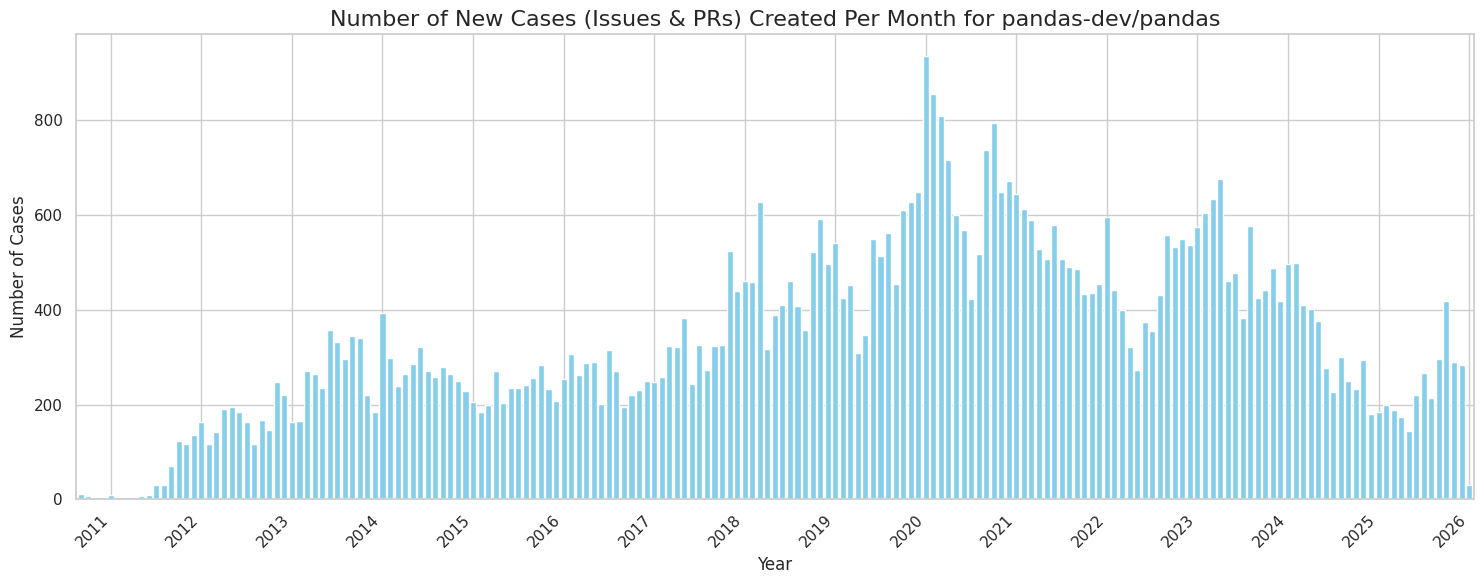


--- 2. User Activity Analysis ---
Total unique users who started a case: 13827
Users who only started 1 case: 9012 (65.18%)


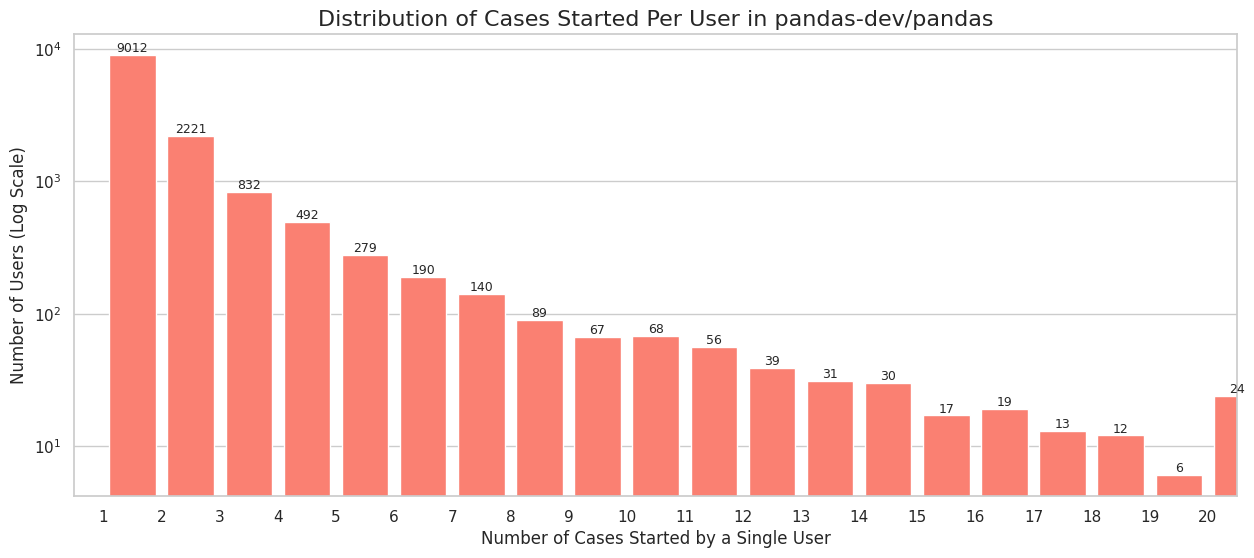

Note: The y-axis is on a log scale to better visualize the long tail of users with many contributions.

--- 3. Case Feedback Analysis ---
Total cases analyzed: 63394
Cases with ZERO comments: 8586 (13.54%)


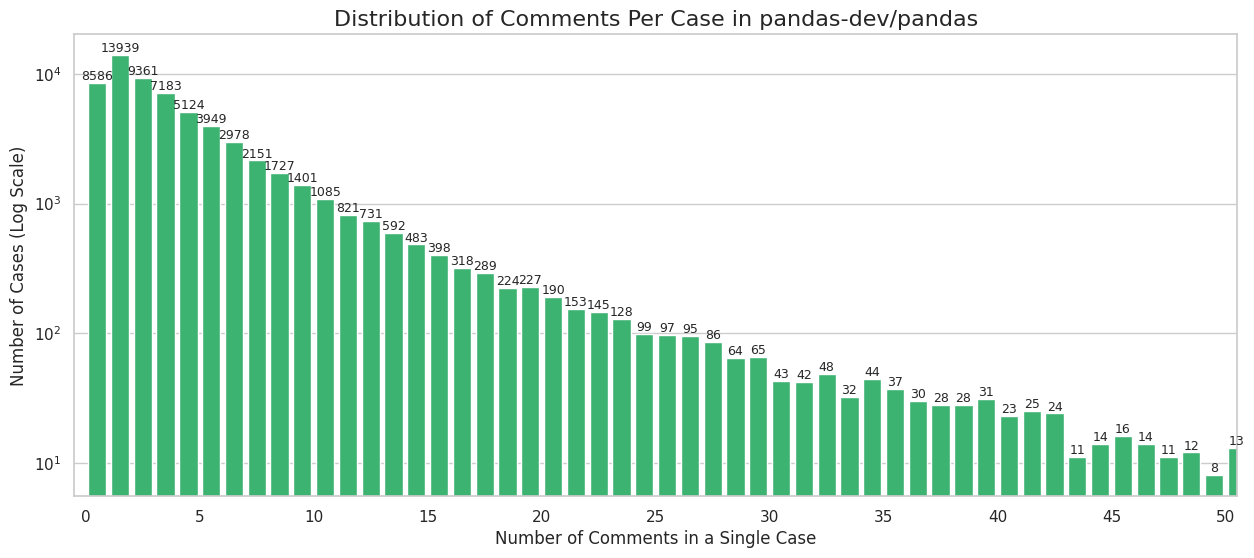

Note: This shows how many cases received 0 comments, 1 comment, 2 comments, etc.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['created_at'] = pd.to_datetime(df['created_at'])
case_starters_df = df[df['type'].isin(['issue_body', 'pull_request_body'])].copy()
sns.set_theme(style="whitegrid")

# ==============================================================================
# Analysis 1: Time-Based Distribution (REVISED PLOTTING)
# ==============================================================================
print("\n--- 1. Time-Based Analysis ---")
if not case_starters_df.empty:
    min_date = case_starters_df['created_at'].min()
    max_date = case_starters_df['created_at'].max()
    print(f"Data ranges from: {min_date.date()} to {max_date.date()}")

    cases_per_month = case_starters_df.set_index('created_at').resample('M').size()

    # --- Start of Changes ---
    fig, ax = plt.subplots(figsize=(15, 6))
    cases_per_month.plot(kind='bar', ax=ax, color='skyblue', width=0.8)

    # Custom tick label logic
    ax.set_xticks([i for i, dt in enumerate(cases_per_month.index) if dt.month == 1])
    ax.set_xticklabels([dt.strftime('%Y') for dt in cases_per_month.index if dt.month == 1])
    # --- End of Changes ---s

    ax.set_title(f'Number of New Cases (Issues & PRs) Created Per Month for {OWNER}/{REPO}', fontsize=16)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Number of Cases', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No cases found to analyze.")

    # ==============================================================================
# Analysis 2: User Contribution Distribution (REVISED PLOTTING)
# ==============================================================================
print("\n--- 2. User Activity Analysis ---")
if not case_starters_df.empty:
    cases_per_user = case_starters_df['author_username'].value_counts()

    total_users, users_with_one_case = len(cases_per_user), (cases_per_user == 1).sum()
    print(f"Total unique users who started a case: {total_users}")
    print(f"Users who only started 1 case: {users_with_one_case} ({users_with_one_case / total_users:.2%})")

    # --- Start of Changes ---
    fig, ax = plt.subplots(figsize=(15, 6))
    counts, bins, patches = ax.hist(cases_per_user, bins=range(1, 22), color='salmon', log=True, rwidth=0.8)

    # Add text annotations to each bar
    for count, patch in zip(counts, patches):
        if count > 0:
            ax.text(patch.get_x() + patch.get_width() / 2, count, str(int(count)),
                    ha='center', va='bottom', fontsize=9)
    # --- End of Changes ---

    ax.set_title(f'Distribution of Cases Started Per User in {OWNER}/{REPO}', fontsize=16)
    ax.set_xlabel('Number of Cases Started by a Single User', fontsize=12)
    ax.set_ylabel('Number of Users (Log Scale)', fontsize=12)
    ax.set_xticks(range(1, 21))
    ax.set_xlim(0.5, 20.5)
    ax.grid(axis='x')
    plt.show()
    print("Note: The y-axis is on a log scale to better visualize the long tail of users with many contributions.")
else:
    print("No users found to analyze.")

# ==============================================================================
# Analysis 3: Case Interaction Analysis (REVISED PLOTTING)
# ==============================================================================
print("\n--- 3. Case Feedback Analysis ---")
if not df.empty:
    comments_df = df[df['type'] == 'comment']
    comments_per_thread = comments_df.groupby('thread_id').size().rename('comment_count')

    analysis_df = case_starters_df.merge(comments_per_thread, on='thread_id', how='left').fillna(0)
    analysis_df['comment_count'] = analysis_df['comment_count'].astype(int)

    total_cases, cases_with_no_comments = len(analysis_df), (analysis_df['comment_count'] == 0).sum()
    print(f"Total cases analyzed: {total_cases}")
    print(f"Cases with ZERO comments: {cases_with_no_comments} ({cases_with_no_comments / total_cases:.2%})")

    # --- Start of Changes ---
    fig, ax = plt.subplots(figsize=(15, 6))
    counts, bins, patches = ax.hist(analysis_df['comment_count'], bins=range(0, 52), color='mediumseagreen', log=True, rwidth=0.8)

    # Add text annotations to each bar
    for count, patch in zip(counts, patches):
        if count > 0:
            ax.text(patch.get_x() + patch.get_width() / 2, count, str(int(count)),
                    ha='center', va='bottom', fontsize=9)
    # --- End of Changes ---

    ax.set_title(f'Distribution of Comments Per Case in {OWNER}/{REPO}', fontsize=16)
    ax.set_xlabel('Number of Comments in a Single Case', fontsize=12)
    ax.set_ylabel('Number of Cases (Log Scale)', fontsize=12)
    ax.set_xticks(range(0, 51, 5))
    ax.set_xlim(-0.5, 50.5)
    ax.grid(axis='x')
    plt.show()
    print("Note: This shows how many cases received 0 comments, 1 comment, 2 comments, etc.")

else:
    print("No data found to analyze.")